In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import covariate_models
import pandas as pd
from pathlib import Path

from skimage.transform import resize
import cv2

In [2]:
metrics=['binary_accuracy', 'AUC']
random_rotate_angles = []

batch_size = 1
shuffle_bool = False

In [3]:
def grad_cam(t, trim=True, trim_sizes = (10, 10, 13)):   

    # Build model and load weights
    model = covariate_models.AD_classifier_plus_tuning_img_only(
        width=182, height=182, depth=218,
        dropout=0.5,
        image_features=100) 

    model.load_weights('../data/saved_models_v2/{}_classifier_182p_tuned_gaussian_labeled_img_only.h5'.format(t)) 
    model.layers[-1].activation = None

    last_conv_layer_name = [x.name for x in model.layers if 'conv3d' in x.name][-1]

    test_img = np.load('../data/matched_images/{}_val/mri_final/{}_val_input_182x182x218_trimmed/0000.npy'.format(t,t))
    test_img = np.expand_dims(test_img, axis=0)

    CLASS_INDEX = 0

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(test_img)
        loss = predictions[:, CLASS_INDEX]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    # Build a ponderated map of filters according to gradients importance
    cam = np.zeros(output.shape[0:3], dtype=np.float32)

    for index, w in enumerate(weights):
        cam += w * output[:, :, :, index]
        
    if trim:
        cam = cam[:trim_sizes[0], :trim_sizes[1], :trim_sizes[2]]
        
    capi=resize(cam,(182,182,218))
#     capi = np.maximum(capi,0)

    heatmap = (capi - capi.min()) / (capi.max() - capi.min())
    
    squeezed_img = test_img.squeeze().astype(np.float32)
    
    return cam, heatmap, squeezed_img

In [36]:
def display_sample_images_one_axis(cam, heatmap, squeezed_img, slice_numbers, alpha=0.5):
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    i = 1

    for slice_number in slice_numbers:       
        cam_slice = cam[int((slice_number/182)*cam.shape[0]), :, :]
        heatmap_slice = (heatmap*255).astype(int)[slice_number, :, :]
        squeezed_img_slice = squeezed_img[slice_number, :, :] 

        # Use jet colormap to colorize heatmap w/ RGB colors
        jet = cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap_slice]

        rgb_img = cv2.cvtColor(squeezed_img_slice, cv2.COLOR_GRAY2RGB)

        # Superimpose the heatmap on original image
        superimposed_img = (jet_heatmap * alpha) + (rgb_img * (1 - alpha))

        plt.subplot(2, len(slice_numbers), i)
        plt.imshow(np.rot90(squeezed_img_slice), cmap='gray')
        
        if i ==1:
            plt.ylabel('MRI', fontsize=18)
            plt.xticks([])
            plt.yticks([])
        else:
            plt.axis('off')

        plt.subplot(2, len(slice_numbers), len(slice_numbers)+i)
        plt.imshow(np.rot90(superimposed_img))

        if i ==1:
            plt.ylabel('Cam Overlaid on MRI', fontsize=18)
            plt.xticks([])
            plt.yticks([])
        else:
            plt.axis('off')
        
        i += 1

        plt.subplots_adjust(wspace=0.1, hspace=0.10)
    
    fig.tight_layout()
    plt.show()

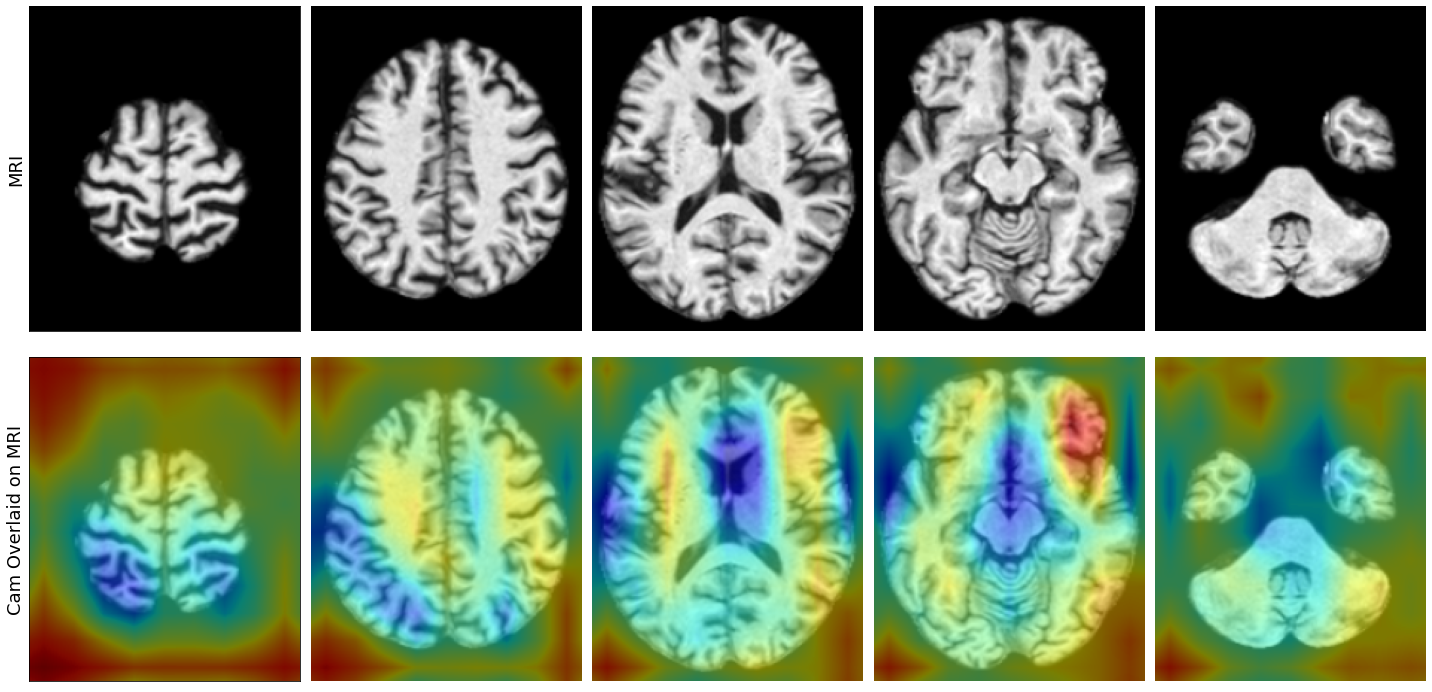

In [38]:
cam, heatmap, img = grad_cam('A', trim_sizes=(9, 9, 12))
display_sample_images_one_axis(cam, heatmap, img, (20, 50, 80, 110, 140))

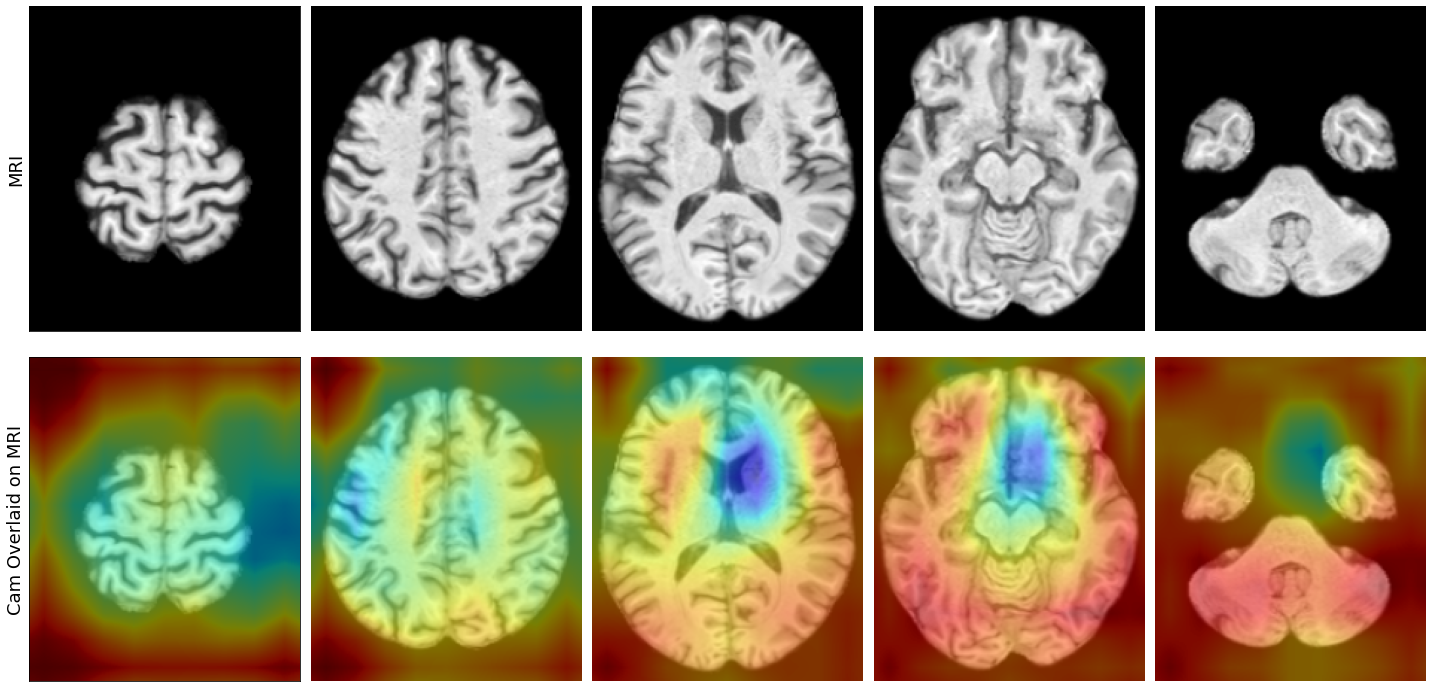

In [41]:
cam, heatmap, img = grad_cam('T', trim_sizes=(9, 9, 12))
display_sample_images_one_axis(cam, heatmap, img, (20, 50, 80, 110, 140))

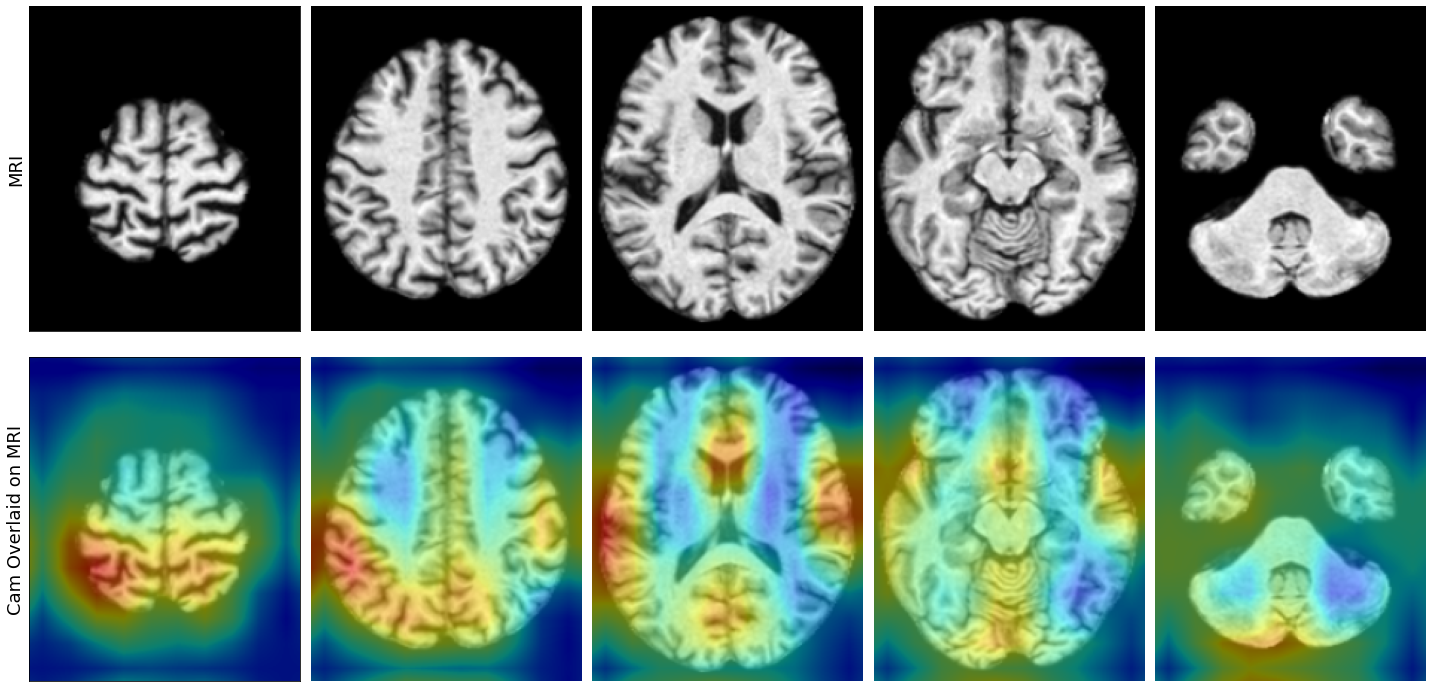

In [42]:
cam, heatmap, img = grad_cam('N')
display_sample_images_one_axis(cam, heatmap, img, (20, 50, 80, 110, 140))